Manga Faces Mood Classifier

Dataset: https://www.kaggle.com/datasets/mertkkl/manga-facial-expressions

References: 

1.   [ \[Pytorch\] - Manga Facial Expression Classificationt](https://www.kaggle.com/code/mertkkl/pytorch-manga-facial-expression-classification/)
2.   [POZZ (MAIS Hacks submission)](https://github.com/amnbot/POZZ/blob/master/jupyter/model.ipynb)


**To look at:**

https://stackoverflow.com/questions/61858768/why-is-the-accuracy-of-my-pretrained-resnet-152-model-so-low


In [3]:
# Imports

import torchvision
import torchvision.datasets as datasets # For importing dataset
import torchvision.models as models # For ResNet-50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import numpy as np
import face_alignment

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device to send data and model to
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device=device)

In [5]:
from PIL import Image, ImageEnhance
# transform class to make images sharper
class Sharpie(object):
    def __init__(self,factor):
        self.factor = factor

    def __call__(self, x):
        enhancer = ImageEnhance.Sharpness(x)
        img = enhancer.enhance(self.factor)
        return img

**From PyTorch [documentation](https://pytorch.org/hub/pytorch_vision_resnet/):**

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

In [64]:
# Image preprocessing
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = 1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

preprocess2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation(45),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = 1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

In [66]:
# Load the dataset
dataset = datasets.ImageFolder('manga-faces', transform=preprocess)
print(len(dataset))
dataset_size = len(dataset)

680


In [67]:
# Split the dataset into training and testing dataset
# Using a 80 % of data for training and 20 % for training
train_size = int(0.9 * dataset_size)
num_display_images = 5
test_size = dataset_size - train_size - num_display_images
train_ds, test_ds, display_imgs = data.random_split(dataset, [train_size, test_size, num_display_images])

In [68]:
train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=15)
test_loader = data.DataLoader(test_ds, shuffle=True, batch_size=10)
display_loader = data.DataLoader(display_imgs, shuffle=True, batch_size=num_display_images)

[Visualizing a grid of images](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py)

['happy', 'shock', 'angry', 'happy', 'crying']


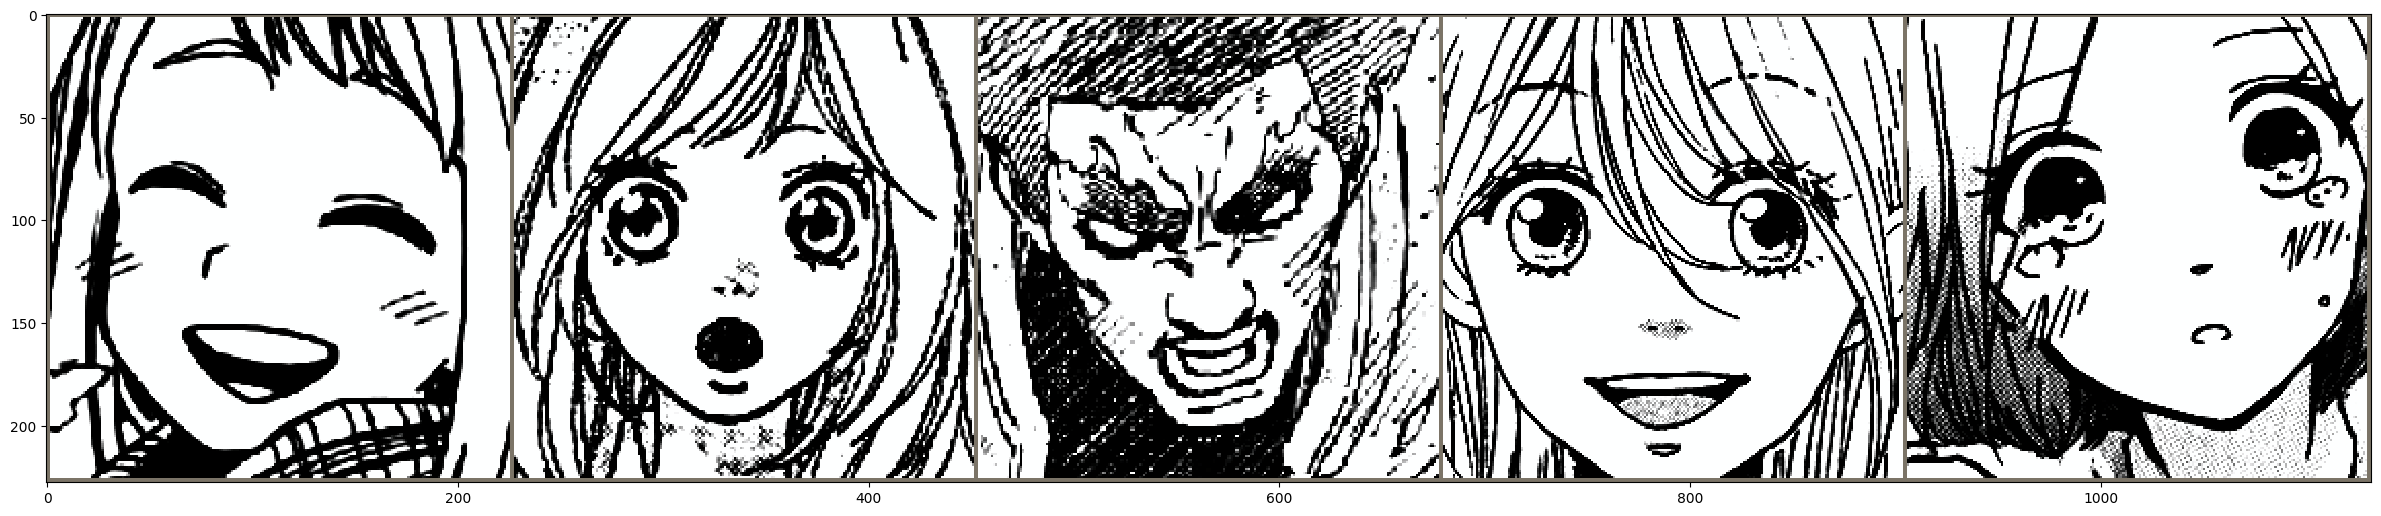

In [69]:
# Display the images (for preprocessing)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Func

def show(imgs):
  ax = plt.subplots(figsize = (30, 90))
  inp = imgs.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp, interpolation='nearest')

inputs, labels = next(iter(display_loader))
idx_to_class = {v: k for k, v in display_loader.dataset.dataset.class_to_idx.items()}
display_moods = []
for label in labels:
  display_moods.append(idx_to_class[int(label)])
print(display_moods)
grid = make_grid(inputs)
show(grid)

**From PyTorch [documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)**

"By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later."

In [9]:
criter = nn.CrossEntropyLoss()
model = models.resnet50(pretrained=True)

# Replace the last fully-connected (fc) layer since we only have 7 classes
for param in model.parameters():
    param.requires_grad  = False

in_feats = model.fc.in_features
num_classes = 7
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device) # Move model to device

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [10]:
# Training function (training done twice, once for the last layer, and another time for the entire model)

def train_model(model, epoch, loss_lst):
  model.train()
  running_loss = 0

  for batch, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device) # Move data to device
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criter(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*inputs.size(0)

    if (batch % 5 == 0):
      print(f'Epoch: {epoch} \t Loss: {loss}')
  
  running_loss /= len(train_loader.dataset)
  loss_lst.append(running_loss)
  print(f'Average loss: {running_loss}')

In [11]:
# Train last layer

num_epochs_last_layer = 30
print('Training last layer...')
train_loss = []
for epoch in range(1, num_epochs_last_layer + 1):
  train_model(model, epoch, train_loss)

Training last layer...
Epoch: 1 	 Loss: 1.871192455291748
Epoch: 1 	 Loss: 1.9792399406433105
Epoch: 1 	 Loss: 2.3471572399139404
Epoch: 1 	 Loss: 1.9497286081314087
Epoch: 1 	 Loss: 1.7484607696533203
Epoch: 1 	 Loss: 1.7686647176742554
Epoch: 1 	 Loss: 1.6544909477233887
Epoch: 1 	 Loss: 1.5811909437179565
Epoch: 1 	 Loss: 1.5360064506530762
Average loss: 2.0116626801444033
Epoch: 2 	 Loss: 1.480570673942566
Epoch: 2 	 Loss: 1.8243484497070312
Epoch: 2 	 Loss: 1.5103965997695923
Epoch: 2 	 Loss: 1.7843579053878784
Epoch: 2 	 Loss: 1.6746087074279785
Epoch: 2 	 Loss: 2.1709649562835693
Epoch: 2 	 Loss: 1.8229992389678955
Epoch: 2 	 Loss: 1.5786997079849243
Epoch: 2 	 Loss: 1.4091092348098755
Average loss: 1.6619514542467453
Epoch: 3 	 Loss: 1.5748889446258545
Epoch: 3 	 Loss: 1.509163498878479
Epoch: 3 	 Loss: 1.6591784954071045
Epoch: 3 	 Loss: 1.9886927604675293
Epoch: 3 	 Loss: 1.4355430603027344
Epoch: 3 	 Loss: 1.3188499212265015
Epoch: 3 	 Loss: 1.1286709308624268
Epoch: 3 	 Los

[2.0116626801444033, 1.6619514542467453, 1.5317726620272094, 1.4207314135981541, 1.3202328997499801, 1.246159308681301, 1.186442388331189, 1.1710437115500956, 1.1039712943282782, 1.1030622188951456, 1.0163052347945232, 0.9720385106755238, 0.9539617931141573, 0.9063045589947233, 0.9158371733684166, 0.8619709375734422, 0.9060066260543524, 0.8235801589839599, 0.8386251846072721, 0.7880300369624998, 0.7923659759701467, 0.7797684294043803, 0.8013906192545798, 0.7348096708164495, 0.7522737670178506, 0.698385375679708, 0.6702114941150534, 0.6846550869591096, 0.6973173859364846, 0.6348979429287069]


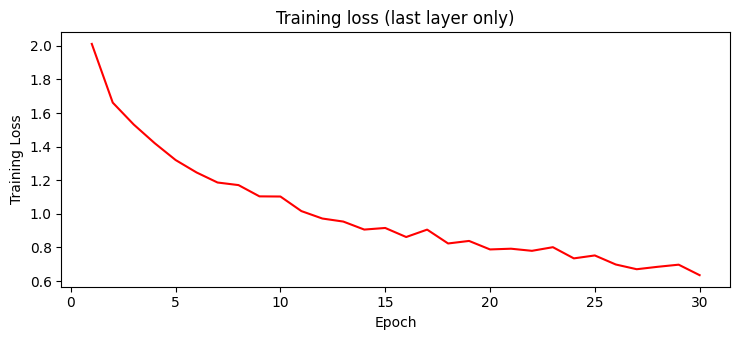

In [12]:
print(train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (last layer only)")
plt.plot(range(1, len(train_loss) + 1), train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

From [docs](https://pytorch.org/docs/stable/generated/torch.argmax.html):



```
>>> a = torch.randn(4, 4)
>>> a
tensor([[ 1.3398,  0.2663, -0.2686,  0.2450],
        [-0.7401, -0.8805, -0.3402, -1.1936],
        [ 0.4907, -1.3948, -1.0691, -0.3132],
        [-1.6092,  0.5419, -0.2993,  0.3195]])
>>> torch.argmax(a, dim=1)
tensor([ 0,  2,  0,  1])
```



In [13]:
# Testing function

def test_model(model, loader, accuracy):
  total = 0
  correct = 0
  preds = []
  targets = []

  model.eval()
  with torch.no_grad():
    
    for batch, (inputs, labels) in enumerate(loader):
      inputs, labels = inputs.to(device), labels.to(device) # Move data to device

      outputs = model(inputs)
      # Use dim=1 to keep an array of the indices of the max values for each output
      pred = outputs.argmax(dim = 1, keepdim = False)
      for p in pred:
        preds.append(int(p))
      for l in labels:
        targets.append(int(l))
      res = torch.eq(pred, labels)
      for r in res:
        total += 1
        if r == True:
          correct += 1
      accuracy.append(correct / total)
      if (batch % 5 == 0):
        print(f'Accuracy: {correct} / {total} ({round((correct / total), 2)} %)')
    return torch.as_tensor(preds), torch.as_tensor(targets)

In [14]:
from torchmetrics import ConfusionMatrix
# Training accuracy for last layer
training_accuracy = []
preds, targets = test_model(model, train_loader, training_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 13 / 15 (0.87 %)
Accuracy: 82 / 90 (0.91 %)
Accuracy: 148 / 165 (0.9 %)
Accuracy: 214 / 240 (0.89 %)
Accuracy: 283 / 315 (0.9 %)
Accuracy: 348 / 390 (0.89 %)
Accuracy: 416 / 465 (0.89 %)
Accuracy: 482 / 540 (0.89 %)
Accuracy: 544 / 612 (0.89 %)


tensor([[ 67,   4,   4,   1,   1,   0,   3],
        [  0,  75,   1,   0,   0,   0,   1],
        [  1,   2,  71,   0,   0,   0,   2],
        [  2,   2,   4, 107,   1,   0,  10],
        [  0,   1,   2,   2,  58,   2,   6],
        [  1,   2,   3,   1,   1,  63,   6],
        [  0,   0,   2,   0,   0,   0, 103]])

In [15]:
from torchmetrics.functional import precision_recall
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.8889), tensor(0.8889))

In [16]:
# Testing accuracy for last layer
testing_accuracy = []
preds, targets = test_model(model, test_loader, testing_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 5 / 10 (0.5 %)
Accuracy: 32 / 60 (0.53 %)


tensor([[ 3,  1,  0,  0,  0,  0,  2],
        [ 0,  3,  1,  0,  0,  0,  0],
        [ 0,  2, 12,  0,  0,  1,  1],
        [ 1,  1,  5,  4,  2,  0,  2],
        [ 1,  0,  0,  1,  2,  1,  1],
        [ 0,  0,  1,  0,  1,  2,  0],
        [ 0,  1,  1,  0,  1,  1,  8]])

In [17]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.5397), tensor(0.5397))

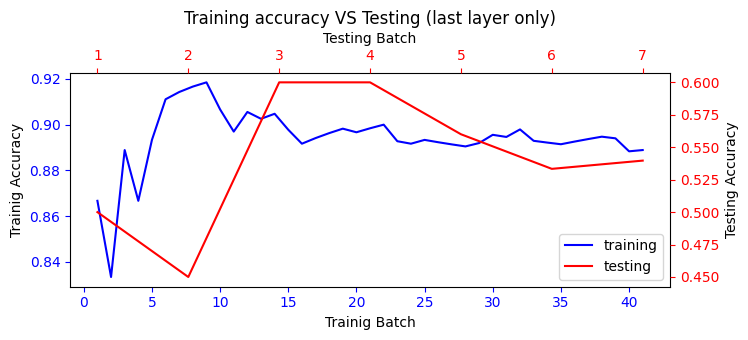

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (last layer only)")

ax.plot(range(1, len(training_accuracy) + 1), training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(testing_accuracy) + 1), testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [19]:
# Set requires_grad = True for the layer
for param in model.parameters():
  param.requires_grad = True

# Train entire model
num_epochs_entire_model = 30
model_train_loss = []
print('Training entire model...')
for epoch in range(1, num_epochs_entire_model + 1):
  train_model(model, epoch, model_train_loss)

Training entire model...
Epoch: 1 	 Loss: 0.515188992023468
Epoch: 1 	 Loss: 1.8954461812973022
Epoch: 1 	 Loss: 2.673776149749756
Epoch: 1 	 Loss: 1.6807055473327637
Epoch: 1 	 Loss: 2.1545655727386475
Epoch: 1 	 Loss: 2.2351531982421875
Epoch: 1 	 Loss: 1.9976919889450073
Epoch: 1 	 Loss: 1.5181317329406738
Epoch: 1 	 Loss: 1.632407784461975
Average loss: 2.238027627853786
Epoch: 2 	 Loss: 1.7415310144424438
Epoch: 2 	 Loss: 1.424525499343872
Epoch: 2 	 Loss: 1.8545202016830444
Epoch: 2 	 Loss: 1.3260502815246582
Epoch: 2 	 Loss: 1.067938208580017
Epoch: 2 	 Loss: 0.9205105900764465
Epoch: 2 	 Loss: 1.4237046241760254
Epoch: 2 	 Loss: 1.1087735891342163
Epoch: 2 	 Loss: 1.250707745552063
Average loss: 1.393895330674508
Epoch: 3 	 Loss: 0.8731251358985901
Epoch: 3 	 Loss: 0.5485782623291016
Epoch: 3 	 Loss: 0.7555023431777954
Epoch: 3 	 Loss: 0.6204595565795898
Epoch: 3 	 Loss: 0.8463500738143921
Epoch: 3 	 Loss: 0.6071779131889343
Epoch: 3 	 Loss: 0.9494637846946716
Epoch: 3 	 Loss: 

[2.238027627853786, 1.393895330674508, 0.9526828999320666, 0.7363741148044082, 0.5825012202794645, 0.39623424096726906, 0.42460244459410507, 0.3989998766166322, 0.2841772853223351, 0.25535188763238054, 0.18941534966157347, 0.26408991824799016, 0.19734971691836037, 0.3165893991678661, 0.3439580856767647, 0.14664959282997778, 0.17924719506545977, 0.11627841522168442, 0.16203061779778377, 0.22678635497668795, 0.22003003014434203, 0.21928280730293515, 0.1899909235117044, 0.13187820477612025, 0.09917852039878056, 0.1086613891198866, 0.15013860964088463, 0.17380379559472203, 0.2544521189148666, 0.18371302917526633]


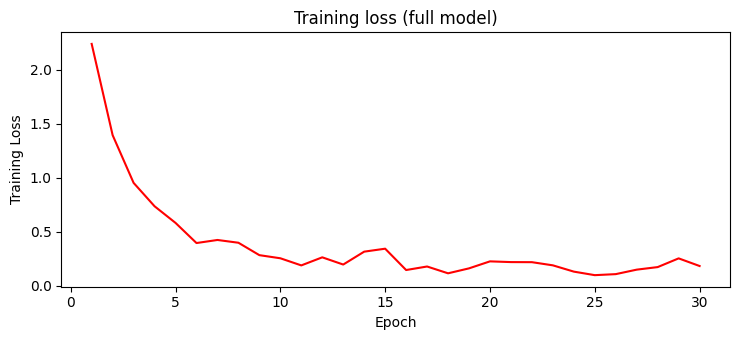

In [20]:
print(model_train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (full model)")
plt.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

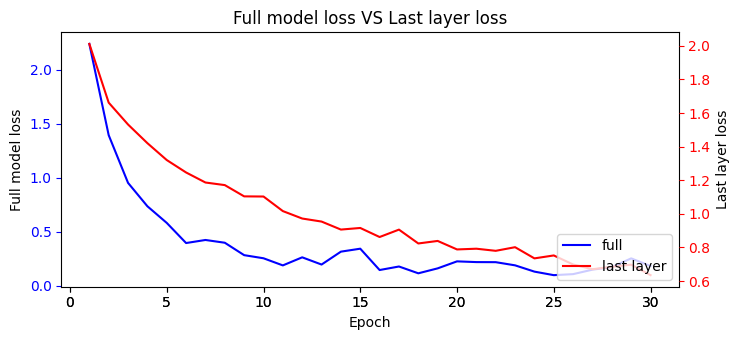

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Full model loss VS Last layer loss")


ax.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="blue", label="full")
ax.set_ylabel("Full model loss")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(train_loss) + 1), train_loss, color="red", label="last layer")
ax2.set_ylabel("Last layer loss")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="red")

plt.xlabel('Epoch')
handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [22]:
# Training accuracy for entire model
model_training_accuracy = []
preds, targets = test_model(model, train_loader, model_training_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 13 / 15 (0.87 %)
Accuracy: 83 / 90 (0.92 %)
Accuracy: 153 / 165 (0.93 %)
Accuracy: 225 / 240 (0.94 %)
Accuracy: 295 / 315 (0.94 %)
Accuracy: 367 / 390 (0.94 %)
Accuracy: 438 / 465 (0.94 %)
Accuracy: 510 / 540 (0.94 %)
Accuracy: 582 / 612 (0.95 %)


tensor([[ 78,   1,   0,   0,   1,   0,   0],
        [  0,  73,   3,   0,   0,   0,   1],
        [  0,   0,  74,   0,   0,   0,   2],
        [  1,   2,   2, 119,   0,   0,   2],
        [  0,   0,   0,   0,  70,   0,   1],
        [  1,   4,   2,   0,   4,  63,   3],
        [  0,   0,   0,   0,   0,   0, 105]])

In [23]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.9510), tensor(0.9510))

In [24]:
# Testing accuracy for entire model
model_testing_accuracy = []
preds, targets = test_model(model, test_loader, model_testing_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 6 / 10 (0.6 %)
Accuracy: 39 / 60 (0.65 %)


tensor([[ 3,  1,  0,  0,  0,  0,  2],
        [ 0,  2,  1,  0,  0,  0,  1],
        [ 0,  2, 13,  0,  0,  0,  1],
        [ 1,  2,  2,  8,  1,  0,  1],
        [ 0,  0,  1,  1,  4,  0,  0],
        [ 0,  0,  0,  0,  3,  1,  0],
        [ 0,  0,  0,  1,  0,  0, 11]])

In [25]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.6667), tensor(0.6667))

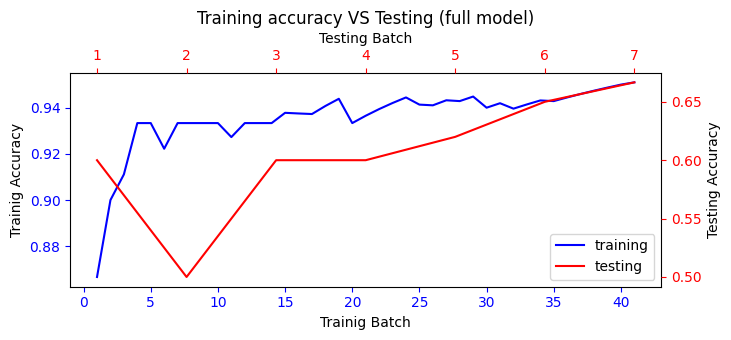

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (full model)")

ax.plot(range(1, len(model_training_accuracy) + 1), model_training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(model_testing_accuracy) + 1), model_testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [27]:
"""
Show a grid of the images, the prediction VS the expected answer
"""

'\nShow a grid of the images, the prediction VS the expected answer\n'

In [28]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted_2.pt') # Save